# Stand Alone Notebook to Evaluate Fine Tuned Gemma Models

### Imports

In [ ]:
# Install Pytorch & other libraries
%pip install "torch>=2.4.0" tensorboard

# Install Gemma release branch from Hugging Face
%pip install "transformers>=4.51.3"

# Install Hugging Face libraries
%pip install  --upgrade \
  "datasets>=3.3.2" \
  "accelerate==1.4.0" \
  "evaluate==0.4.3" \
  "bitsandbytes==0.45.3" \
  "trl==0.21.0" \
  "peft==0.14.0" \
  "protobuf==5.29.1" \
  "fsspec==2025.3.0" \
  python-Levenshtein \
  sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.1/342.1 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.9/511.9 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.8/374.8 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 100.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: protobuf
    Foun

In [ ]:
import os
os.environ["HF_HUB_DISABLE_XET"] = "1"

import jax
print("JAX backend:", jax.default_backend())
print("JAX devices:", jax.devices())

JAX backend: gpu
JAX devices: [CudaDevice(id=0)]


In [ ]:
from google.colab import drive
from google.colab import userdata
from huggingface_hub import login

import matplotlib.pyplot as plt
import seaborn as sns

import os
from pathlib import Path
import json
import random
import re
import sqlite3

import torch
from datasets import load_dataset
import pandas as pd
import Levenshtein

from huggingface_hub import login
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForImageTextToText,
    BitsAndBytesConfig,
)
from peft import LoraConfig, PeftModel
from trl import SFTConfig, SFTTrainer

# Login into Hugging Face Hub
hf_token = userdata.get('HF_TOKEN') # If you are running inside a Google Colab
login(hf_token)

### Setup Repo Structure

In [ ]:
drive.mount('/content/drive')

ROOT_DRIVE_DIR = "/content/drive/MyDrive/gemma_lora_ft"

WIKISQL_DIR = Path("/content/WikiSQL")

DATA_DIR = Path("/content/data")

TRAINED_MODEL_NAME = "gemma_text_to_sql_run_train_rank_32_20251208_075911"

TRAINED_MODEL_DIR = f"{ROOT_DRIVE_DIR}/{TRAINED_MODEL_NAME}"


Mounted at /content/drive


### System/User Prompt with Prompt Builder

In [ ]:
# User prompt template (used in both training & inference)

def generate_raw_prompt(question: str, schema_text: str) -> str:
    return f"""<INSTRUCTIONS>
You are a precise text-to-SQL generator. Using the known schema of the sql database you must output only a valid SQL query and nothing else.
</INSTRUCTIONS>

<SCHEMA>
{schema_text}
</SCHEMA>

<QUESTION>
{question}
</QUESTION>

<SQL_Query>
""".strip()

# Load Test WikiSQL Dataset

In [ ]:
if not os.path.exists(WIKISQL_DIR):
  !git clone https://github.com/salesforce/WikiSQL

if not os.path.exists(DATA_DIR):
  !tar xvjf /content/WikiSQL/data.tar.bz2

Cloning into 'WikiSQL'...
remote: Enumerating objects: 389, done.
remote: Counting objects: 100% (195/195), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 389 (delta 186), reused 154 (delta 154), pack-reused 194 (from 1)
Receiving objects: 100% (389/389), 50.72 MiB | 12.71 MiB/s, done.
Resolving deltas: 100% (213/213), done.
data/
data/train.jsonl
data/test.tables.jsonl
data/test.db
data/dev.tables.jsonl
data/dev.db
data/test.jsonl
data/train.tables.jsonl
data/train.db
data/dev.jsonl


### SQLite Setup and Table Builder

In [ ]:
def load_tables(split="dev"):
    tables_path = DATA_DIR / f"{split}.tables.jsonl"
    tables = {}
    with open(tables_path, "r", encoding="utf-8") as f:
        for line in f:
            obj = json.loads(line)
            tables[obj["id"]] = obj
    return tables


def iter_split(split="dev"):
    q_path = DATA_DIR / f"{split}.jsonl"
    tables = load_tables(split)
    with open(q_path, "r", encoding="utf-8") as f:
        for line in f:
            ex = json.loads(line)
            table = tables[ex["table_id"]]
            yield ex, table


def build_sqlite_from_table(table_obj):
    df = pd.DataFrame(table_obj["rows"], columns=table_obj["header"])
    conn = sqlite3.connect(":memory:")
    df.to_sql("data", conn, index=False, if_exists="replace")
    return conn


AGG_OPS = ["", "MAX", "MIN", "COUNT", "SUM", "AVG"]
COND_OPS = ["=", ">", "<", "OP"]


def escape_identifier(name: str) -> str:
    # Escape internal quotes by doubling them
    cleaned = name.replace('"', '""')
    return f'"{cleaned}"'


def logical_to_sql(sql_obj, table_obj, table_name="data"):
    sel_idx = sql_obj["sel"]
    agg_idx = sql_obj["agg"]
    conds = sql_obj["conds"]

    columns = table_obj["header"]
    sel_col = escape_identifier(columns[sel_idx])
    agg = AGG_OPS[agg_idx]

    # FIX: Proper aggregation syntax
    if agg == "":
        select_expr = sel_col
    else:
        select_expr = f"{agg}({sel_col})"

    query = f"SELECT {select_expr} FROM {table_name}"

    where_clauses = []
    for col_idx, op_idx, val in conds:
        col_name = escape_identifier(columns[col_idx])
        op = COND_OPS[op_idx]

        if isinstance(val, str):
            v_str = "'" + val.replace("'", "''") + "'"
        else:
            v_str = str(val)

        if op == "OP":
            op = "="

        where_clauses.append(f"{col_name} {op} {v_str}")

    if where_clauses:
        query += " WHERE " + " AND ".join(where_clauses)

    return query

def execute_sql(conn, sql):
    try:
        cur = conn.cursor()
        cur.execute(sql)
        return cur.fetchall(), None
    except Exception as e:
        return None, str(e)


def make_schema_text(table_obj):
    """
    Convert WikiSQL table to the same schema format used for synthetic data,
    so the model sees consistent inputs.
    """
    cols = table_obj["header"]
    return "\n".join(f"- {c} (TEXT)" for c in cols)

### Test SQL Helper Functions

In [ ]:
import sqlite3
import re

def is_sql_syntax_valid(sql):
    """
    Checks SQL syntax by replacing table names with a dummy table
    so that missing tables do NOT cause an error.
    """
    sql_clean = sql.strip()

    # Replace any token after FROM or JOIN with the dummy table name
    sql_clean = re.sub(r"(FROM|JOIN)\s+[\w\.\-]+", r"\1 dummy", sql_clean, flags=re.IGNORECASE)

    conn = sqlite3.connect(":memory:")
    conn.execute("CREATE TABLE dummy(x TEXT);")

    try:
        conn.execute(sql_clean)
        return True
    except Exception as e:
        if "no such table" in str(e).lower():
            return True   # table does not exist → ignore
        return False


In [ ]:
wikisql_valid = 0
wikisql_total = 0
wikisql_errors = []

for ex, tbl in iter_split("test"):
    wikisql_total += 1

    conn = build_sqlite_from_table(tbl)
    sql = logical_to_sql(ex["sql"], tbl)

    result, err = execute_sql(conn, sql)

    if err is None:
        wikisql_valid += 1
    else:
        wikisql_errors.append((sql, err))

print(f"WikiSQL valid queries: {wikisql_valid}/{wikisql_total} "
      f"({wikisql_valid / wikisql_total:.2%})")

print("\nExample WikiSQL errors:")
if not wikisql_errors:
    print("No errors — all WikiSQL queries are valid!")
else:
    for i, (sql, err) in enumerate(wikisql_errors[:5]):
        print("SQL:", sql)
        print("ERROR:", err, "\n")


WikiSQL valid queries: 15878/15878 (100.00%)

Example WikiSQL errors:
No errors — all WikiSQL queries are valid!


### Final Data Preprocessing

In [ ]:
from datasets import Dataset

def normalize_sql(sql: str) -> str:
    sql = sql.strip().rstrip(";")
    sql = sql.replace("`", '"')
    return sql

def build_completion(sql: str) -> str:
    sql = normalize_sql(sql)
    return sql.lstrip() + "\n</SQL_Query>"

def build_training_row_from_wikisql(ex, tbl):
    schema = make_schema_text(tbl)
    prompt = generate_raw_prompt(ex["question"], schema)
    gold_sql = logical_to_sql(ex["sql"], tbl)
    completion = build_completion(gold_sql)

    return {
        "prompt": prompt,
        "completion": completion
    }


### Build Datasets

In [ ]:
train_rows = []
for ex, tbl in iter_split("train"):
    train_rows.append(build_training_row_from_wikisql(ex, tbl))

test_rows = []
for ex, tbl in iter_split("test"):
    test_rows.append(build_training_row_from_wikisql(ex, tbl))

val_rows = []
for ex, tbl in iter_split("dev"):
    val_rows.append(build_training_row_from_wikisql(ex, tbl))

train_wikisql = Dataset.from_list(train_rows)
test_wikisql = Dataset.from_list(test_rows)
val_wikisql = Dataset.from_list(val_rows)

print(train_wikisql)
print(test_wikisql)
print(val_wikisql)

# print("\n")

# for i in range(3):
#     print("PROMPT:\n", train_wikisql[i]["prompt"])
#     print("COMPLETION:\n", train_wikisql[i]["completion"])
#     print("="*80)


Dataset({
    features: ['prompt', 'completion'],
    num_rows: 56355
})
Dataset({
    features: ['prompt', 'completion'],
    num_rows: 15878
})
Dataset({
    features: ['prompt', 'completion'],
    num_rows: 8421
})


# Training Visualizations

### Load Training Log

In [ ]:
# Paths
TRAINING_LOG_PATH = f"{TRAINED_MODEL_DIR}/training_log.json"

# Load JSON list of dicts
with open(TRAINING_LOG_PATH, "r") as f:
    log_history = json.load(f)

print("Loaded", len(log_history), "log entries.")

Loaded 1443 log entries.


### Plotting Functions

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os


# ===========================
#  PLOTTING UTIL
# ===========================

def _save_or_show(save_path):
    """Helper: save figure if path is provided, else show."""
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        plt.close()
        print(f"Saved plot to: {save_path}")
    else:
        plt.show()


# ===========================
#   LOSS CURVE + EMA
# ===========================

def plot_loss(df: pd.DataFrame, span: int = 50, save_path: str = None):
    """
    Plot raw loss + EMA-smoothed loss.
    """
    if "loss" not in df.columns:
        print("No `loss` column found in dataframe.")
        return

    df = df.copy()
    df["loss_ema"] = df["loss"].ewm(span=span).mean()

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x="step", y="loss", alpha=0.4, label="Raw Loss")
    sns.lineplot(data=df, x="step", y="loss_ema", label=f"EMA Loss (span={span})")

    plt.title("Training Loss (LoRA Rank=32, Alpha=16 | Raw vs EMA Smoothed)")
    plt.xlabel("Training Step")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    _save_or_show(save_path)


# ===========================
#   GRADIENT NORM
# ===========================

def plot_grad_norm(df: pd.DataFrame, save_path: str = None):
    """
    Plot gradient norm over training.
    """
    if "grad_norm" not in df.columns:
        print("No `grad_norm` column found in dataframe.")
        return

    grad_df = df.dropna(subset=["grad_norm"])

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=grad_df, x="step", y="grad_norm")

    plt.title("Gradient Norm Over Training (LoRA Rank=32, Alpha=16)")
    plt.xlabel("Training Step")
    plt.ylabel("Grad Norm")
    plt.grid(True)

    _save_or_show(save_path)


# ===========================
#   TOKEN ACCURACY
# ===========================

def plot_token_accuracy(df: pd.DataFrame, save_path: str = None):
    """
    Plot mean token accuracy over training.
    """
    if "mean_token_accuracy" not in df.columns:
        print("No `mean_token_accuracy` column found in dataframe.")
        return

    acc_df = df.dropna(subset=["mean_token_accuracy"])

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=acc_df, x="step", y="mean_token_accuracy")

    plt.title("Mean Token Accuracy Over Time (LoRA Rank=32, Alpha=16)")
    plt.xlabel("Training Step")
    plt.ylabel("Mean Token Accuracy")
    plt.grid(True)

    _save_or_show(save_path)


# ===========================
#   LEARNING RATE
# ===========================

def plot_learning_rate(df: pd.DataFrame, save_path: str = None):
    """
    Plot learning rate schedule.
    """
    if "learning_rate" not in df.columns:
        print("No `learning_rate` column found in dataframe.")
        return

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x="step", y="learning_rate")

    plt.title("Learning Rate Over Training (LoRA Rank=32, Alpha=16)")
    plt.xlabel("Training Step")
    plt.ylabel("Learning Rate")
    plt.grid(True)

    _save_or_show(save_path)


In [ ]:
training_metrics_df = pd.DataFrame(log_history)

plot_loss(training_metrics_df, save_path=f"{TRAINED_MODEL_DIR}/training_loss.png")
plot_grad_norm(training_metrics_df, save_path=f"{TRAINED_MODEL_DIR}/training_grad_norm.png")
plot_token_accuracy(training_metrics_df, save_path=f"{TRAINED_MODEL_DIR}/token_accuracy.png")

Saved plot to: /content/drive/MyDrive/gemma_lora_ft/gemma_text_to_sql_run_train_rank_32_20251208_075911/training_loss.png
Saved plot to: /content/drive/MyDrive/gemma_lora_ft/gemma_text_to_sql_run_train_rank_32_20251208_075911/training_grad_norm.png
Saved plot to: /content/drive/MyDrive/gemma_lora_ft/gemma_text_to_sql_run_train_rank_32_20251208_075911/token_accuracy.png


# Evaluation Functions

### Generate Cleaned SQL Query from Gemma Model with Prompt

In [ ]:
import re

def clean_sql_output(text: str) -> str:
    """
    Extract a clean SQL statement from LLM output under the new tag-based format:

        <SQL_Query>
        SELECT ...
        </SQL_Query>

    Handles:
      - missing or extra whitespace
      - missing closing tags
      - trailing commentary after </SQL_Query>
      - selects the FIRST valid SQL statement
    """

    if not text or not isinstance(text, str):
        return ""

    raw = text.strip()

    # -------------------------------
    # 1. Extract content inside <SQL_Query> ... </SQL_Query>
    # -------------------------------
    m = re.search(
        r"<SQL_Query>(.*?)(</SQL_Query>|$)",
        raw,
        flags=re.IGNORECASE | re.DOTALL,
    )

    if m:
        candidate = m.group(1).strip()
    else:
        # fallback if tag missing
        candidate = raw

    # Remove any accidental tag echoes
    candidate = re.sub(r"</?SQL_Query>", "", candidate, flags=re.IGNORECASE).strip()

    # Strip markdown fences if any
    candidate = re.sub(r"```sql", "", candidate, flags=re.IGNORECASE)
    candidate = candidate.replace("```", "").strip()

    # Normalize whitespace
    candidate = re.sub(r"[ \t]+", " ", candidate)

    # -------------------------------
    # 2. Grab the first SQL keyword (fallback)
    # -------------------------------
    sql_start = re.compile(
        r"\b(SELECT|INSERT\s+INTO|UPDATE|DELETE\s+FROM|CREATE\s+TABLE)\b",
        flags=re.IGNORECASE,
    )

    match = sql_start.search(candidate)
    if not match:
        return candidate  # return raw candidate (probably empty)

    sql = candidate[match.start():].strip()

    # -------------------------------
    # 3. Remove trailing commentary or extra content
    # -------------------------------
    stop_tokens = [
        "</SQL_Query>",
        "<INSTRUCTIONS>",
        "<QUESTION>",
        "<SCHEMA>",
        "Explanation:",
        "Answer:",
        "Result:",
        "Note:",
        "\n#",
        "```",
    ]

    end_positions = []
    for tok in stop_tokens:
        pos = sql.find(tok)
        if pos > 0:
            end_positions.append(pos)

    if end_positions:
        sql = sql[:min(end_positions)].strip()

    # Remove trailing punctuation
    sql = sql.rstrip(";` ")

    return sql.strip()



def generate_sql_from_llm(question: str, schema_text: str, model) -> str:
    """
    Generate SQL from a raw text prompt using continuation-style generation.
    """
    # Build the same raw prompt used during training
    prompt = generate_raw_prompt(question, schema_text)

    # print(prompt)

    # Tokenize
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    print
    # Compute input length to slice off the prompt from model output
    input_len = inputs["input_ids"].shape[-1]

    # Generate continuation
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=150,
            do_sample=False,  # deterministic for evaluation
            pad_token_id=tokenizer.eos_token_id
        )

    # Slice off the prompt to isolate model-generated SQL
    gen_tokens = outputs[0][input_len:]
    decoded = tokenizer.decode(gen_tokens, skip_special_tokens=True)

    return clean_sql_output(decoded)


# SQL similarity score evaluator
def tokenize_sql(sql: str):
    sql = sql.lower()
    sql = re.sub(r"[^a-z0-9_*]", " ", sql)
    tokens = sql.split()
    return tokens

### Optional Case Insensitivity Function

In [ ]:
def apply_case_insensitive_matching(sql: str) -> str:
    """
    Rewrites any equality of the form:
        "Column" = 'Value'
    into:
        "Column" = 'Value' COLLATE NOCASE
    Only applies to string literal comparisons.
    """

    # pattern matches: "Column" = 'Value'
    pattern = r'(".*?")\s*=\s*(\'[^\']*\')'

    def repl(match):
        col, val = match.groups()
        return f'{col} = {val} COLLATE NOCASE'

    return re.sub(pattern, repl, sql)


### Semantic Similarity Functions

In [ ]:
def jaccard_similarity(sql1: str, sql2: str) -> float:
    """
    Jaccard similarity over token sets.
    Returns value in [0,1].
    """
    t1 = set(tokenize_sql(sql1))
    t2 = set(tokenize_sql(sql2))

    if not t1 and not t2:
        return 1.0
    return len(t1 & t2) / len(t1 | t2)


def levenshtein_similarity(sql1: str, sql2: str) -> float:
    """
    Normalized Levenshtein similarity.
    1.0 = identical strings.
    """
    sql1 = sql1.lower().strip()
    sql2 = sql2.lower().strip()

    if not sql1 and not sql2:
        return 1.0

    dist = Levenshtein.distance(sql1, sql2)
    max_len = max(len(sql1), len(sql2))

    if max_len == 0:
        return 1.0
    return 1 - (dist / max_len)




In [ ]:
def extract_select_columns(sql: str):
    """
    Extract SELECT columns robustly.
    Handles cases like:
       SELECT a, b FROM ...
       SELECT COUNT(a) FROM ...
       SELECT MAX("col name") FROM ...
    """
    sql = sql.lower().strip()
    m = re.search(r"select\s+(.*?)\s+from", sql)
    if not m:
        return set()

    cols = m.group(1)

    # Remove function wrappers like count(), max(), avg()
    cols = re.sub(r"\b(count|max|min|sum|avg)\s*\(", "", cols)
    cols = cols.replace(")", "")

    # Split multiple columns
    parts = [c.strip(' "\'') for c in cols.split(",")]
    return set(p for p in parts if p)


def extract_where_columns(sql: str):
    """
    Extract WHERE clause column names.
    Handles AND, multiple conditions, operators, quoted columns.
    """
    sql = sql.lower().strip()
    m = re.search(r"where\s+(.*)", sql)
    if not m:
        return set()

    conditions = m.group(1)

    # Split by AND
    conds = re.split(r"\band\b", conditions)

    cols = []
    for cond in conds:
        parts = cond.strip().split()
        if parts:
            col = parts[0].strip('"\'')
            cols.append(col)

    return set(cols)

def extract_sql_operators(sql: str):
    """
    Extract operators used in SQL conditions.
    """
    ops = set()
    for op in ["=", ">", "<", "!=", "<=", ">=", "like"]:
        if op in sql.lower():
            ops.add(op)
    return ops


def structural_similarity(sql1: str, sql2: str):
    """
    Returns a dict with:
       - select_match
       - where_match
       - op_match
    Each value is in [0,1].
    """

    s1_select = extract_select_columns(sql1)
    s2_select = extract_select_columns(sql2)

    s1_where = extract_where_columns(sql1)
    s2_where = extract_where_columns(sql2)

    s1_ops = extract_sql_operators(sql1)
    s2_ops = extract_sql_operators(sql2)

    def overlap(a, b):
        if not a and not b:
            return 1.0
        return len(a & b) / max(1, len(a | b))

    return {
        "select_match": overlap(s1_select, s2_select),
        "where_match": overlap(s1_where, s2_where),
        "op_match": overlap(s1_ops, s2_ops),
    }


### Experiment Evaluation Function

In [ ]:
%pip install sacrebleu rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 10.0 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=63c34d217d9a8c38b02ff6802cd2985303324c045acbc83b1941555a7715b4ae
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [ ]:
import random
import json
import time
from tqdm import tqdm
import pandas as pd
import evaluate
from collections import Counter

# -----------------------------
#   NEW SUPPORT FUNCTIONS
# -----------------------------

bleu_metric = evaluate.load("sacrebleu")
rouge_metric = evaluate.load("rouge")


def normalize_sql_for_em(sql: str) -> str:
    sql = sql.strip().lower()
    sql = sql.replace("`", '"')
    sql = " ".join(sql.split())   # Collapse whitespace
    return sql


def sql_tokenize(s: str):
    s = s.lower()
    s = re.sub(r'[^a-z0-9_]+', ' ', s)
    return s.split()


def f1_score(pred: str, gold: str):
    pred_tokens = sql_tokenize(pred)
    gold_tokens = sql_tokenize(gold)

    common = Counter(pred_tokens) & Counter(gold_tokens)
    num_same = sum(common.values())

    if len(pred_tokens) == 0 or len(gold_tokens) == 0:
        return int(pred_tokens == gold_tokens)

    precision = num_same / len(pred_tokens)
    recall = num_same / len(gold_tokens)
    if precision + recall == 0:
        return 0.0
    return 2 * precision * recall / (precision + recall)


# -----------------------------
#   MAIN ENHANCED EVALUATOR
# -----------------------------

def evaluate_model(
    model,
    sample_fraction=0.10,
    case_insensitive_sql=True,
    log_path=None,
    verbose=False,
    seed=42
):
    """
    Full evaluation over a sample of the WikiSQL test set.
    Includes:
      - Execution validity & correctness
      - Jaccard / Levenshtein / Structural similarity
      - BLEU, ROUGE, Exact Match, Token F1
    Saves:
      - Row-level log (JSONL)
      - Summary statistics (appended to same log_path if provided)
    """

    random.seed(seed)

    examples = list(iter_split("test"))
    total = len(examples)
    sample_size = int(total * sample_fraction)

    sampled = random.sample(examples, sample_size)

    rows = []
    start_time = time.time()

    gold_list = []
    pred_list = []

    for idx, (ex, tbl) in enumerate(tqdm(sampled, desc="Evaluating")):
        conn = build_sqlite_from_table(tbl)
        schema = make_schema_text(tbl)

        # Gold SQL + execution
        gold_sql = logical_to_sql(ex["sql"], tbl)
        gold_res, gold_err = execute_sql(conn, gold_sql)

        # Model prediction
        pred_sql = generate_sql_from_llm(ex["question"], schema, model)
        pred_sql_exec = apply_case_insensitive_matching(pred_sql) if case_insensitive_sql else pred_sql
        pred_res, pred_err = execute_sql(conn, pred_sql_exec)

        # Track for ROUGE/BLEU/EM/F1
        gold_list.append(gold_sql)
        pred_list.append(pred_sql)

        # Custom similarity metrics
        jac = jaccard_similarity(gold_sql, pred_sql)
        lev = levenshtein_similarity(gold_sql, pred_sql)
        struct = structural_similarity(gold_sql, pred_sql)

        # Execution scoring
        exec_valid = (pred_err is None)
        exec_correct = (exec_valid and gold_err is None and pred_res == gold_res)

        rows.append({
            "question": ex["question"],
            "schema": schema,
            "gold_sql": gold_sql,
            "pred_sql": pred_sql,
            "pred_sql_exec": pred_sql_exec,
            "gold_res": gold_res,
            "pred_res": pred_res,
            "gold_err": gold_err,
            "pred_err": pred_err,
            "exec_valid": exec_valid,
            "exec_correct": exec_correct,
            "jaccard": jac,
            "levenshtein": lev,
            "select_match": struct["select_match"],
            "where_match": struct["where_match"],
            "op_match": struct["op_match"],
        })

        if verbose and idx % 50 == 0:
            print(f"[{idx}/{sample_size}] exec_valid={exec_valid} exec_correct={exec_correct}")

    # Build row-level DataFrame
    df = pd.DataFrame(rows)

    # -----------------------------
    #   GLOBAL METRIC COMPUTATION
    # -----------------------------

    # BLEU
    bleu_score = bleu_metric.compute(
        predictions=[p.lower() for p in pred_list],
        references=[[g.lower()] for g in gold_list]
    )

    # ROUGE
    rouge_scores = rouge_metric.compute(
        predictions=[p.lower() for p in pred_list],
        references=[g.lower() for g in gold_list]
    )

    # Exact Match
    em_scores = [
        normalize_sql_for_em(p) == normalize_sql_for_em(g)
        for p, g in zip(pred_list, gold_list)
    ]
    em = sum(em_scores) / len(em_scores)

    # Token F1
    f1_scores = [
        f1_score(p, g)
        for p, g in zip(pred_list, gold_list)
    ]
    avg_f1 = sum(f1_scores) / len(f1_scores)

    # Execution metrics
    exec_valid_rate = df["exec_valid"].mean()
    exec_correct_rate = df["exec_correct"].mean()

    # -----------------------------
    #   SUMMARY DICTIONARY
    # -----------------------------
    summary = {
        "samples_evaluated": sample_size,
        "execution_valid_rate": exec_valid_rate,
        "execution_correct_rate": exec_correct_rate,
        "BLEU": bleu_score,
        "ROUGE": rouge_scores,
        "Exact_Match": em,
        "Token_F1": avg_f1,
        "avg_jaccard": df["jaccard"].mean(),
        "avg_levenshtein": df["levenshtein"].mean(),
    }

    # -----------------------------
    #   LOG RESULTS (JSONL + summary)
    # -----------------------------
    if log_path:
        # Save row-level predictions
        df.to_json(log_path, orient="records", lines=True)

        # Save summary as separate JSON
        summary_path = log_path.replace(".jsonl", "_summary.json")
        with open(summary_path, "w") as f:
            json.dump(summary, f, indent=2)

        print(f"\nSaved detailed log to: {log_path}")
        print(f"Saved summary statistics to: {summary_path}")

    elapsed = time.time() - start_time
    print(f"\nEvaluation completed in {elapsed/60:.2f} minutes.")
    print("\nSummary Metrics:\n", json.dumps(summary, indent=2))

    return df, summary


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Experiment Evaluation Result Helper Functions

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set_theme(style="whitegrid")


# =====================================================
# 1. EXECUTION SUMMARY
# =====================================================
def plot_execution_summary(df, save=False, save_path="execution_summary.png"):
    summary = pd.DataFrame({
        "Metric": ["Execution Valid", "Execution Correct"],
        "Proportion": [
            df["exec_valid"].mean(),
            df["exec_correct"].mean()
        ]
    })

    plt.figure(figsize=(8, 5))
    ax = sns.barplot(
        data=summary,
        x="Metric",
        y="Proportion",
        hue="Metric",
        palette=["#76a5ff", "#4c8aff"],
        dodge=False
    )
    ax.set_ylim(0, 1)
    ax.set_title("SQL Execution Performance Overview (Baseline)", fontsize=17, weight="bold")
    ax.set_ylabel("Proportion of Predictions")

    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", fontsize=12, label_type="center")

    plt.tight_layout()
    if save:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()


# =====================================================
# 2. SIMILARITY DISTRIBUTION HISTOGRAMS
# =====================================================
def plot_similarity_distributions(df, save=False, save_path="similarity_scores.png"):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    sns.histplot(df["jaccard"], kde=True, ax=axes[0], bins=25, color="#4a90e2")
    axes[0].set_title("Jaccard Similarity Distribution (Baseline)", fontsize=15, weight="bold")
    axes[0].set_xlabel("Jaccard Score")
    axes[0].set_xlim(0, 1)

    sns.histplot(df["levenshtein"], kde=True, ax=axes[1], bins=25, color="#50c878")
    axes[1].set_title("Levenshtein Similarity Distribution (Baseline)", fontsize=15, weight="bold")
    axes[1].set_xlabel("Normalized Levenshtein Score")
    axes[1].set_xlim(0, 1)

    fig.suptitle("Semantic Similarity Between Gold & Predicted SQL", fontsize=18, weight="bold")
    plt.tight_layout()

    if save:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()


# =====================================================
# 3. ERROR BREAKDOWN (Improved layout + centered labels)
# =====================================================
def plot_error_breakdown(df, save=False, save_path="error_breakdown.png"):
    fig, ax = plt.subplots(figsize=(10, 6))

    sns.countplot(
        data=df,
        y="err_type",
        palette=["#8BC6FF", "#FFD39B", "#FF9B8E"],
        ax=ax
    )

    ax.set_title("SQL Prediction Error Breakdown (Baseline)", fontsize=18, weight="bold")
    ax.set_xlabel("Number of Cases")
    ax.set_ylabel("Error Category")

    # Center numeric labels inside bars
    for container in ax.containers:
        ax.bar_label(container, fontsize=12, label_type="center")

    # Move explanation to right side
    fig.text(
        0.72, 0.55,
        "Legend:\n"
        "✓ Correct — matches gold result\n"
        "⚠ Wrong Result — valid SQL, wrong output\n"
        "✗ SQL Error — syntax/execution failure",
        fontsize=11,
        va="center",
        bbox=dict(facecolor="white", edgecolor="gray", alpha=0.8)
    )

    plt.subplots_adjust(right=0.72)

    if save:
        fig.savefig(save_path, bbox_inches="tight")
    plt.show()


# =====================================================
# 4. BLEU / ROUGE OVERVIEW CHART
# =====================================================
def plot_text_metrics(summary_dict, save=False, save_path="nlp_metrics.png"):
    metrics = {
        "BLEU": summary_dict["BLEU"]["score"],
        "ROUGE-L": summary_dict["ROUGE"]["rougeL"],
        "Exact Match": summary_dict["Exact_Match"],
        "Token F1": summary_dict["Token_F1"]
    }

    plt.figure(figsize=(9, 5))
    ax = sns.barplot(
        x=list(metrics.keys()),
        y=list(metrics.values()),
        palette="viridis"
    )

    ax.set_ylim(0, 1)
    ax.set_title("Text-Based SQL Generation Metrics (Baseline)", fontsize=18, weight="bold")
    ax.set_ylabel("Score (0-1)")

    for container in ax.containers:
        ax.bar_label(container, fmt="%.3f", fontsize=12, label_type="center")

    plt.tight_layout()
    if save:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()


# =====================================================
# 5. EXACT MATCH / TOKEN F1 DISTRIBUTIONS
# =====================================================
def plot_em_f1_distributions(df, save=False, save_path="em_f1_dist.png"):
    plt.figure(figsize=(12, 5))

    metrics_df = pd.DataFrame({
        "Exact Match": df["em"],
        "Token F1": df["f1"]
    })

    sns.boxplot(data=metrics_df, palette="Set2")

    plt.title("Exact Match & Token F1 Distribution (Baseline)", fontsize=17, weight="bold")
    plt.ylabel("Score")

    if save:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()


# =====================================================
# 6. SCATTER: SIMILARITY vs EXECUTION CORRECTNESS
# =====================================================
def plot_similarity_vs_correctness(df, save=False, save_path="similarity_vs_correctness.png"):
    plt.figure(figsize=(8, 6))

    sns.scatterplot(
        data=df,
        x="jaccard",
        y="levenshtein",
        hue="exec_correct",
        palette={True: "#1f77b4", False: "#ff7f0e"},
        alpha=0.7
    )

    plt.title("Similarity Scores vs SQL Execution Correctness (Baseline)", fontsize=17, weight="bold")
    plt.xlabel("Jaccard")
    plt.ylabel("Levenshtein")

    if save:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()


# =====================================================
# 7. RADAR CHART (Overall Model Quality Profile)
# =====================================================
def plot_radar_summary(summary_dict, save=False, save_path="radar_summary.png"):
    labels = ["BLEU", "ROUGE-L", "Exact Match", "Token F1"]
    values = [
        summary_dict["BLEU"]["score"],
        summary_dict["ROUGE"]["rougeL"],
        summary_dict["Exact_Match"],
        summary_dict["Token_F1"]
    ]

    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False)
    values = np.concatenate((values, [values[0]]))
    angles = np.concatenate((angles, [angles[0]]))

    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))
    ax.plot(angles, values, linewidth=2, linestyle='solid')
    ax.fill(angles, values, alpha=0.25)

    ax.set_thetagrids(angles[:-1] * 180/np.pi, labels)
    ax.set_title("Model Quality Radar Chart (Baseline)", fontsize=18, weight="bold")

    ax.set_ylim(0, 1)

    if save:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()


# Load Trained Model

### Load Baseline Model

In [ ]:
# Hugging Face model id
model_id = "google/gemma-3-4b-pt"  # pre-trained (not instruction-tuned)
# For tokenizer we use the instruction-tuned tokenizer
tokenizer_id = "google/gemma-3-4b-it"

# Select model class based on id
if model_id == "google/gemma-3-4b-pt":
    model_class = AutoModelForCausalLM
else:
    model_class = AutoModelForImageTextToText

# Choose dtype based on GPU capability
if torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8:
    torch_dtype = torch.bfloat16
else:
    torch_dtype = torch.float16

# Define model init arguments
model_kwargs = dict(
    attn_implementation="sdpa", # Use "flash_attention_2" when running on Ampere or newer GPU
    torch_dtype=torch_dtype, # What torch dtype to use, defaults to auto
    device_map="auto", # Let torch decide how to load the model
)

model_kwargs["quantization_config"] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=model_kwargs['torch_dtype'],
    bnb_4bit_quant_storage=model_kwargs['torch_dtype'],
)


print("🔄 Loading model...")
base_model = model_class.from_pretrained(model_id, **model_kwargs)

print("🔄 Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(tokenizer_id)

# Ensure tokenizer has EOS & PAD set correctly for generation & SFT
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"


🔄 Loading model...


config.json:   0%|          | 0.00/815 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

🔄 Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

### Apply LoRA Adapters

In [ ]:
# ft_model = PeftModel.from_pretrained(base_model, TRAINED_MODEL_DIR)
# ft_model.print_trainable_parameters()

### Test Model Output Anecdotally

In [ ]:
examples = list(iter_split("test"))

for i in range(5):                        # get 5 examples
    ex, tbl = examples[i+1000]

    conn = build_sqlite_from_table(tbl)
    schema = make_schema_text(tbl)

    gold_sql = logical_to_sql(ex["sql"], tbl)
    pred_sql = generate_sql_from_llm(ex["question"], schema, base_model)

    gold_res, ge = execute_sql(conn, gold_sql)

    pred_sql = apply_case_insensitive_matching(pred_sql)
    pred_res, pe = execute_sql(conn, pred_sql)

    print(f"\n### Example {i}")
    print("Q:", ex["question"])
    print("Gold:", gold_sql)
    print("Pred:", pred_sql)
    print("Gold result:", gold_res)
    print("Pred result:", pred_res if pe is None else f"ERROR: {pe}")

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



### Example 0
Q: Who is the director of the episode that corresponds to the total episodes number 14? 
Gold: SELECT "Director" FROM data WHERE "Total#" = 14
Pred: SELECT Director FROM Series WHERE Total = 14
Gold result: [('Ciaran Donnelly',)]
Pred result: ERROR: no such table: Series

### Example 1
Q: What's the title of the episode that Rob Heyland wrote? 
Gold: SELECT "Title" FROM data WHERE "Writer" = 'Rob Heyland'
Pred: SELECT Title FROM Total WHERE Writer = 'Rob Heyland'
Gold result: [('" For England…! "',)]
Pred result: ERROR: no such table: Total

### Example 2
Q: What number from the total number of episodes is the episode written by Julian Unthank?
Gold: SELECT "Series#" FROM data WHERE "Writer" = 'Julian Unthank'
Pred: SELECT * FROM Total# WHERE Title = 'Julian Unthank'
Gold result: [(4,)]
Pred result: ERROR: unrecognized token: "#"

### Example 3
Q: How many touchdowns did Redden score?
Gold: SELECT MIN("Touchdowns") FROM data WHERE "Player" = 'Redden'
Pred: SELECT Player,

# Final Comparison Experiment

### Setup Experiment

### Run Experiment On Baseline Model

### Run Experiment on (3)? Trained Models

In [ ]:
eval_df, summary_metrics = evaluate_model(
    base_model,
    sample_fraction=0.10,
    case_insensitive_sql=True,
    log_path=f"{TRAINED_MODEL_DIR}/eval_results_baseline.jsonl",
    verbose=True,
    seed=42
)

Evaluating:   0%|          | 1/1587 [00:02<54:50,  2.07s/it]

[0/1587] exec_valid=False exec_correct=False


Evaluating:   3%|▎         | 51/1587 [02:49<1:16:24,  2.98s/it]

[50/1587] exec_valid=False exec_correct=False


Evaluating:   6%|▋         | 101/1587 [05:23<55:13,  2.23s/it]

[100/1587] exec_valid=False exec_correct=False


Evaluating:  10%|▉         | 151/1587 [07:44<1:13:41,  3.08s/it]

[150/1587] exec_valid=False exec_correct=False


Evaluating:  13%|█▎        | 201/1587 [10:49<1:12:22,  3.13s/it]

[200/1587] exec_valid=False exec_correct=False


Evaluating:  16%|█▌        | 251/1587 [13:46<1:00:02,  2.70s/it]

[250/1587] exec_valid=False exec_correct=False


Evaluating:  19%|█▉        | 301/1587 [16:13<1:05:40,  3.06s/it]

[300/1587] exec_valid=False exec_correct=False


Evaluating:  22%|██▏       | 351/1587 [18:57<1:01:33,  2.99s/it]

[350/1587] exec_valid=False exec_correct=False


Evaluating:  25%|██▌       | 401/1587 [21:27<53:18,  2.70s/it]

[400/1587] exec_valid=False exec_correct=False


Evaluating:  28%|██▊       | 451/1587 [24:09<1:10:32,  3.73s/it]

[450/1587] exec_valid=False exec_correct=False


Evaluating:  32%|███▏      | 501/1587 [26:56<1:10:43,  3.91s/it]

[500/1587] exec_valid=False exec_correct=False


Evaluating:  35%|███▍      | 551/1587 [30:05<1:11:46,  4.16s/it]

[550/1587] exec_valid=False exec_correct=False


Evaluating:  38%|███▊      | 601/1587 [33:04<1:06:32,  4.05s/it]

[600/1587] exec_valid=False exec_correct=False


Evaluating:  41%|████      | 651/1587 [35:35<37:28,  2.40s/it]

[650/1587] exec_valid=False exec_correct=False


Evaluating:  44%|████▍     | 701/1587 [38:47<1:04:40,  4.38s/it]

[700/1587] exec_valid=False exec_correct=False


Evaluating:  47%|████▋     | 751/1587 [41:41<48:44,  3.50s/it]

[750/1587] exec_valid=False exec_correct=False


Evaluating:  50%|█████     | 801/1587 [44:32<33:19,  2.54s/it]

[800/1587] exec_valid=False exec_correct=False


Evaluating:  54%|█████▎    | 851/1587 [47:01<29:19,  2.39s/it]

[850/1587] exec_valid=False exec_correct=False


Evaluating:  57%|█████▋    | 901/1587 [49:26<50:33,  4.42s/it]

[900/1587] exec_valid=False exec_correct=False


Evaluating:  60%|█████▉    | 951/1587 [52:01<28:17,  2.67s/it]

[950/1587] exec_valid=False exec_correct=False


Evaluating:  63%|██████▎   | 1001/1587 [54:45<30:46,  3.15s/it]

[1000/1587] exec_valid=False exec_correct=False


Evaluating:  66%|██████▌   | 1051/1587 [57:33<29:04,  3.26s/it]

[1050/1587] exec_valid=False exec_correct=False


Evaluating:  69%|██████▉   | 1101/1587 [1:00:15<27:27,  3.39s/it]

[1100/1587] exec_valid=False exec_correct=False


Evaluating:  73%|███████▎  | 1151/1587 [1:02:57<26:03,  3.59s/it]

[1150/1587] exec_valid=False exec_correct=False


Evaluating:  76%|███████▌  | 1201/1587 [1:05:31<16:28,  2.56s/it]

[1200/1587] exec_valid=False exec_correct=False


Evaluating:  79%|███████▉  | 1251/1587 [1:07:58<19:31,  3.49s/it]

[1250/1587] exec_valid=False exec_correct=False


Evaluating:  82%|████████▏ | 1301/1587 [1:11:00<21:50,  4.58s/it]

[1300/1587] exec_valid=False exec_correct=False


Evaluating:  85%|████████▌ | 1351/1587 [1:14:26<12:56,  3.29s/it]

[1350/1587] exec_valid=False exec_correct=False


Evaluating:  88%|████████▊ | 1401/1587 [1:17:07<07:45,  2.50s/it]

[1400/1587] exec_valid=False exec_correct=False


Evaluating:  91%|█████████▏| 1451/1587 [1:20:19<08:55,  3.94s/it]

[1450/1587] exec_valid=False exec_correct=False


Evaluating:  95%|█████████▍| 1501/1587 [1:23:10<07:42,  5.38s/it]

[1500/1587] exec_valid=False exec_correct=False


Evaluating:  98%|█████████▊| 1551/1587 [1:25:49<01:32,  2.57s/it]

[1550/1587] exec_valid=False exec_correct=False


Evaluating: 100%|██████████| 1587/1587 [1:27:47<00:00,  3.32s/it]



Saved detailed log to: /content/drive/MyDrive/gemma_lora_ft/gemma_text_to_sql_run_train_rank_32_20251208_075911/eval_results_baseline.jsonl
Saved summary statistics to: /content/drive/MyDrive/gemma_lora_ft/gemma_text_to_sql_run_train_rank_32_20251208_075911/eval_results_baseline_summary.json

Evaluation completed in 87.81 minutes.

Summary Metrics:
 {
  "samples_evaluated": 1587,
  "execution_valid_rate": 0.0,
  "execution_correct_rate": 0.0,
  "BLEU": {
    "score": 12.594390342716494,
    "counts": [
      15324,
      4642,
      2277,
      1001
    ],
    "totals": [
      30769,
      29182,
      27595,
      26008
    ],
    "precisions": [
      49.80337352530144,
      15.907065999588788,
      8.251494836021019,
      3.8488157490003077
    ],
    "bp": 1.0,
    "sys_len": 30769,
    "ref_len": 28843
  },
  "ROUGE": {
    "rouge1": 0.7184847261105305,
    "rouge2": 0.4344842006898131,
    "rougeL": 0.6696477646974877,
    "rougeLsum": 0.6713239061572853
  },
  "Exact_Match"

### Optional Load in Eval Statistics

In [ ]:
eval_df = pd.read_json(f"{TRAINED_MODEL_DIR}/eval_results_baseline.jsonl", lines=True)
summary_metrics = json.load(open(f"{TRAINED_MODEL_DIR}/eval_results_baseline_summary.json", "r"))
print("DataFrame loaded successfully.")
print(eval_df.head())
print(summary_metrics)

DataFrame loaded successfully.
                                            question  \
0  Who is the Head Coach of the team whose Presid...   
1  How many 'number of seasons in top division' w...   
2  What height was the forward position at Crocke...   
3  What is the score for the 2nd leg when Belasic...   
4  Who is the winning driver of Penske Racing, an...   

                                              schema  \
0  - Team (TEXT)\n- Head Coach (TEXT)\n- Presiden...   
1  - Club (TEXT)\n- First season in top division ...   
2  - Name (TEXT)\n- # (TEXT)\n- Position (TEXT)\n...   
3  - Team 1 (TEXT)\n- Agg. (TEXT)\n- Team 2 (TEXT...   
4  - Name (TEXT)\n- Pole Position (TEXT)\n- Faste...   

                                            gold_sql  \
0  SELECT "Head Coach" FROM data WHERE "President...   
1  SELECT MAX("Number of seasons in top division"...   
2  SELECT "Height" FROM data WHERE "Position" = '...   
3  SELECT "2nd leg" FROM data WHERE "Team 2" = 'b...   
4  SELECT "Winn

### Process Evaluation Output

In [ ]:
# print(summary_metrics)
# print(summary_metrics)

def classify_error(row):
    if row["exec_correct"]:
        return "Correct"
    if row["exec_valid"]:
        return "Wrong Result"
    return "SQL Error"

def compute_exact_match(gold, pred):
    return gold.strip() == pred.strip()

def compute_f1(gold, pred):
    gold_tokens = gold.lower().split()
    pred_tokens = pred.lower().split()
    common = len(set(gold_tokens) & set(pred_tokens))
    if len(gold_tokens) == 0 or len(pred_tokens) == 0:
        return 0.0
    precision = common / len(pred_tokens)
    recall = common / len(gold_tokens)
    if precision + recall == 0:
        return 0.0
    return 2 * precision * recall / (precision + recall)

In [ ]:

eval_df["err_type"] = eval_df.apply(classify_error, axis=1)
eval_df["em"] = eval_df.apply(lambda r: compute_exact_match(r["gold_sql"], r["pred_sql"]), axis=1)
eval_df["f1"] = eval_df.apply(lambda r: compute_f1(r["gold_sql"], r["pred_sql"]), axis=1)


In [ ]:
print(type(eval_df))
print(eval_df.columns)

print(eval_df.head())

<class 'pandas.core.frame.DataFrame'>
Index(['question', 'schema', 'gold_sql', 'pred_sql', 'pred_sql_exec',
       'gold_res', 'pred_res', 'gold_err', 'pred_err', 'exec_valid',
       'exec_correct', 'jaccard', 'levenshtein', 'select_match', 'where_match',
       'op_match', 'err_type', 'em', 'f1'],
      dtype='object')
                                            question  \
0  Who is the Head Coach of the team whose Presid...   
1  How many 'number of seasons in top division' w...   
2  What height was the forward position at Crocke...   
3  What is the score for the 2nd leg when Belasic...   
4  Who is the winning driver of Penske Racing, an...   

                                              schema  \
0  - Team (TEXT)\n- Head Coach (TEXT)\n- Presiden...   
1  - Club (TEXT)\n- First season in top division ...   
2  - Name (TEXT)\n- # (TEXT)\n- Position (TEXT)\n...   
3  - Team 1 (TEXT)\n- Agg. (TEXT)\n- Team 2 (TEXT...   
4  - Name (TEXT)\n- Pole Position (TEXT)\n- Faste...   

   

### Plot Execution and Other Evaluation Metrics

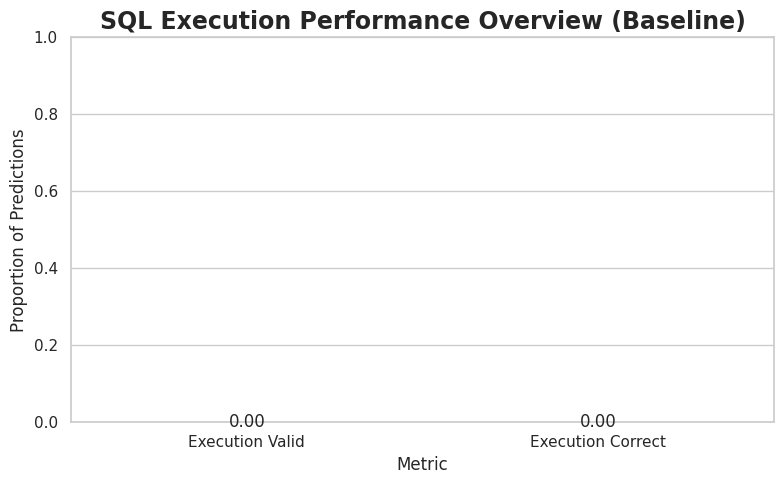

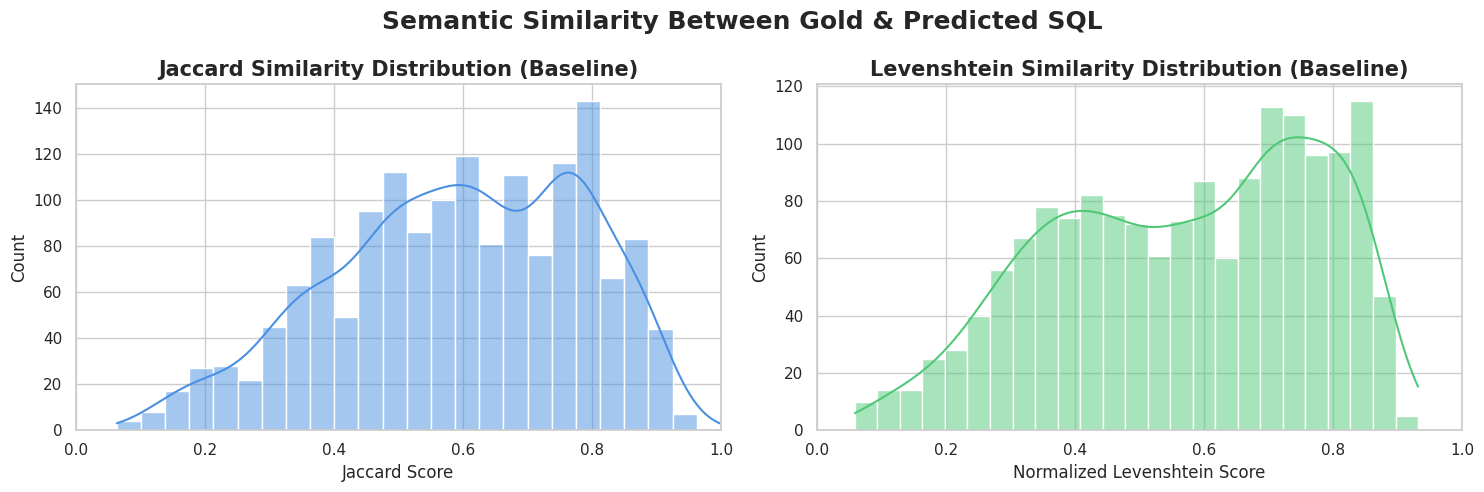

/tmp/ipython-input-619593083.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
/tmp/ipython-input-619593083.py:73: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.countplot(


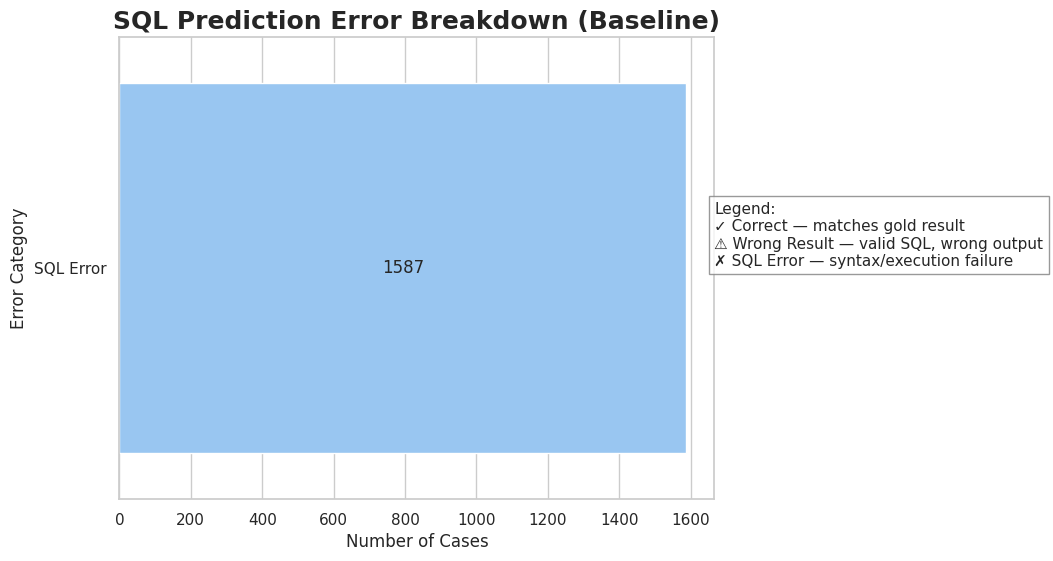

/tmp/ipython-input-619593083.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


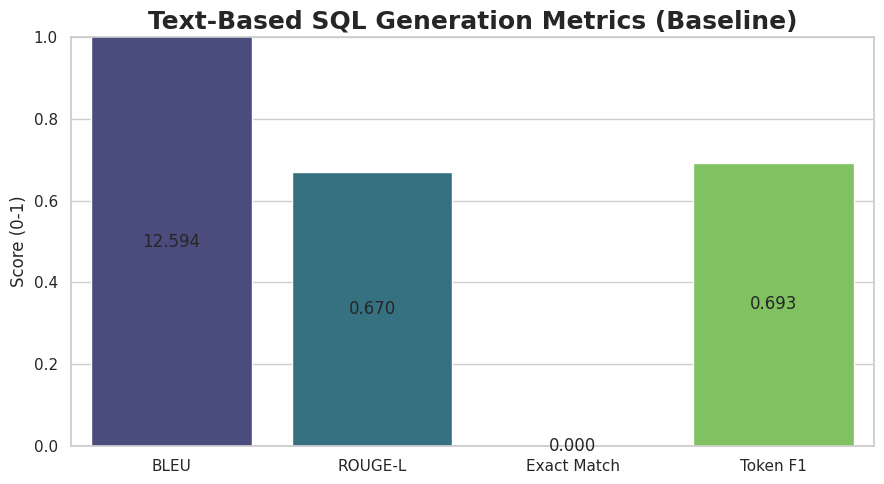

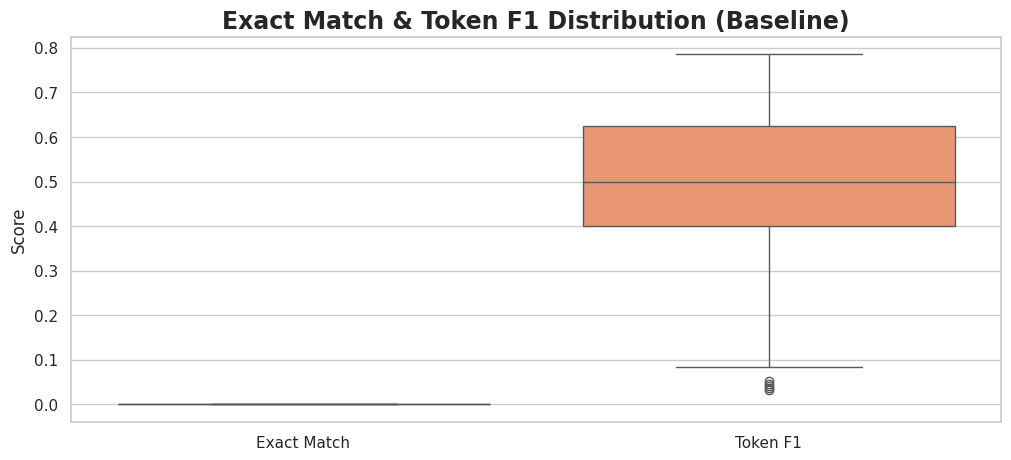

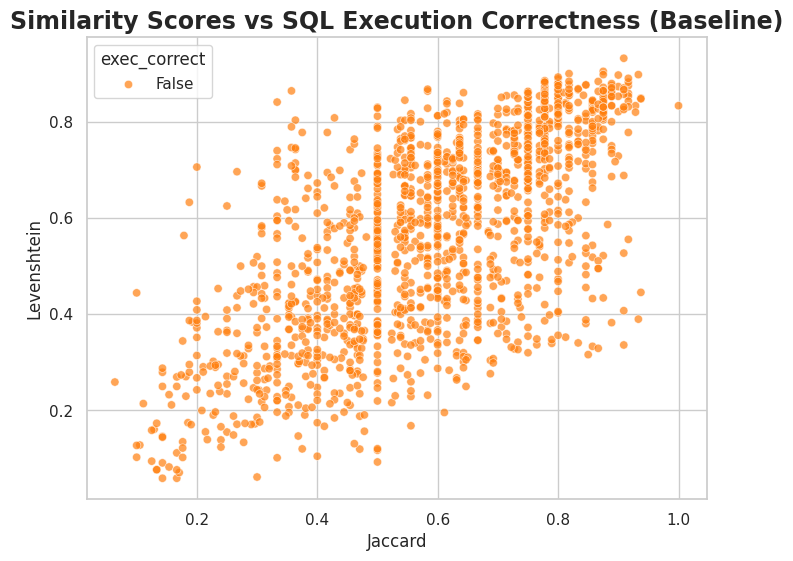

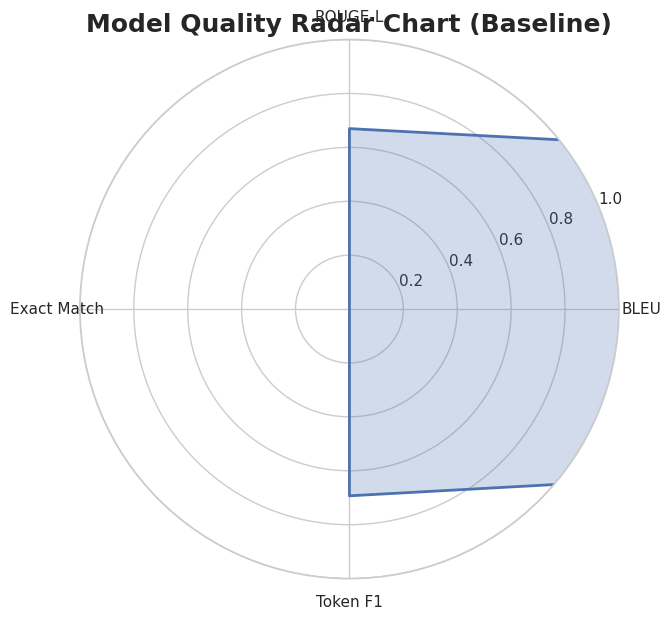

In [ ]:
# 1. Execution summary
plot_execution_summary(
    eval_df,
    save=True,
    save_path=f"{TRAINED_MODEL_DIR}/execution_summary_baseline.png"
)

# 2. Similarity distributions
plot_similarity_distributions(
    eval_df,
    save=True,
    save_path=f"{TRAINED_MODEL_DIR}/similarity_distributions_baseline.png"
)

# 3. Error type breakdown
plot_error_breakdown(
    eval_df,
    save=True,
    save_path=f"{TRAINED_MODEL_DIR}/error_breakdown_baseline.png"
)

# 4. NLP text metrics (BLEU, ROUGE, EM, F1)
plot_text_metrics(
    summary_metrics,
    save=True,
    save_path=f"{TRAINED_MODEL_DIR}/nlp_text_metrics_baseline.png"
)

# 5. Exact Match & F1 distributions
plot_em_f1_distributions(
    eval_df,
    save=True,
    save_path=f"{TRAINED_MODEL_DIR}/em_f1_distribution_baseline.png"
)

# 6. Similarity vs correctness scatter plot
plot_similarity_vs_correctness(
    eval_df,
    save=True,
    save_path=f"{TRAINED_MODEL_DIR}/similarity_vs_correctness_baseline.png"
)

# 7. Radar chart of overall model performance
plot_radar_summary(
    summary_metrics,
    save=True,
    save_path=f"{TRAINED_MODEL_DIR}/radar_summary_baseline.png"
)